# Transfer Learning

Author: Sahngyoon Rhee

Training a neural network often involves a huge amount of data as well as extensive computational resources. Training a neural network can take days or weeks, and sometime it's not possible for someone with limited data or with limited computational resources to make a machine learning model from scratch that has desirable accuracy. Transfer Learning is one way of dealing with this problem.

Transfer learning is the use of model structures and/or parameters that others have trained on their data for our own machine learning project. In transfer learning, one adopts a model that others have trained, make some modifications on one or more of the layers to be suitable for our own needs, and either (1) fine-tune the model, i.e. start out with the pretrained parameters as initial weights and retrain the whole model, or (2) freeze some layers of the adopted model and (re)train only a portion of the model.

One example of transfer learning is using ChatGPT, or any other Large Language Model (LLM), for specific tasks within a company. Another example of transfer learning is using an image classifier to classify only a few hundreds of personal images.

In this notebook, we shall use PyTorch to come up with a convolutional neural network via transfer learning.

Much of what follows came from [Sasank Chilakurthy's tutorial on PyTorch documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [1]:
# import necessary packages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms # the `models` is crucial for transfer learning
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode on, for visualization

## Loading the Data

We shall train a binary classification model, classifying pictures of ants and bees. We have a small dataset - 120 training images for ants and the same for bees. There are 75 validation images for each class.

Because there are so few images in our training set, we will employ data augmentation, as well as normaliation, for the training set. We will also employ normalization for validation set.

In [2]:
# Data Augmentation and normaization for training
# added normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'

# set up datasets using torchvision.datasets.ImageFolder, applying the transformations composed above
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Use GPU cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualizing images

We shall now visualize a few training images so that we can see in our own eyes how the data augmentation has been done.

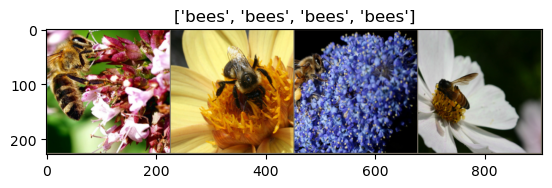

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    # The input, which may be a Tensor of dimension [C, H, W], gets converted to dimension [H, W, C], which is suitable for plt.imshow
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean

    # limits the values in `input` to be between 0 and 1, e.g. a value 1.7 will be clipped to be 1
    # necessary for displaying images in black and weight
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

We shall write a general function to train a model. Through the code below, we shall demonstrate how to schedule the learning rate through `torch.optim.lr_scheduler`. In essence, we shall make the learning rate smaller after we progress through more and more epochs. This will make our step in gradient descent smaller as we get closer and closer to local minimum of the loss function, instead of wiggling around - but not necessarily getting closer to - the local minimum.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing model predictions

We shall write a general function to display predictions for a few images.

In [5]:
def visualize_model(model, num_images=6):
    # saves the current state of the model (training mode or evaluation mode) before switching to evaluation mode.
    # useful for restoring the model’s state after the visualization is done
    was_training = model.training
    
    # sets the model to evaluation model to stop gradient tracking
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                # inputs.cpu() moves the input to CPU, since plt.imshow only works with data in CPU and not in GPU
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        # ensures that the model's mode is restored even if fewer than num_images images are visualized
        model.train(mode=was_training)

## Finetuning the ConvNet

We are now ready to demonstrate finetuning. We shall use the ResNet18, which has 18 layers; other models available in `torchvision.models` are `resnet34`, `resnet50`, and so on, with the number for each indicating the number of layers in that model.

 The model was pretrained on the ImageNet images, which contains 1.2 milion images with 1000 categories. Due to the large number of training images used to pretrained the model, the model already is quite well performing on its own. However, since the output layer for the adopted model has 1000 numbers as outputs, we want to modify our model a bit so that it becomes a binary classifier.

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In learning how exactly the SGD with Momentum works, please check out this [Deeplearning.AI video](https://www.youtube.com/watch?v=k8fTYJPd3_I). The idea is that it uses the Exponential Weighted Moving Average ( EWMA) without the bias correction) to smooth out each gradeint descent step by averaging, with weights, the previous few (to be precise, approximately the previous $\frac{1}{1-\beta}$ where $\beta$ is the `momentum` value) values of gradients. In our specific case, with `momentum = .9`, we are using the approximate $10$ previouse values of the gradient values for gradient descent.

### Train and Evaluate

We now train the data. It will take a few minutes on CPU.

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 6)

Epoch 0/5
----------
train Loss: 0.6537 Acc: 0.6721
val Loss: 0.2237 Acc: 0.9281

Epoch 1/5
----------
train Loss: 0.4626 Acc: 0.8074
val Loss: 0.2172 Acc: 0.9346

Epoch 2/5
----------
train Loss: 0.4406 Acc: 0.8156
val Loss: 0.2126 Acc: 0.9281

Epoch 3/5
----------
train Loss: 0.4354 Acc: 0.8074
val Loss: 0.2281 Acc: 0.9216

Epoch 4/5
----------
train Loss: 0.5119 Acc: 0.8033
val Loss: 0.2804 Acc: 0.8693

Epoch 5/5
----------
train Loss: 0.4635 Acc: 0.8156
val Loss: 0.3544 Acc: 0.8431

Training complete in 11m 41s
Best val Acc: 0.934641


C:\Users\srhee\AppData\Local\Temp\ipykernel_10884\1058781594.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


We see that, even with only 5 iterations, we have an over 90% Accuracy on the validation set. Even with data augmnetation, this may not have been possible. This shows the power of using transfer learning.

## Visualize some Model Predictions

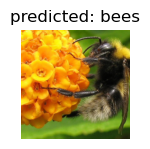

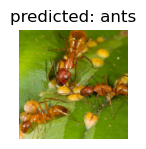

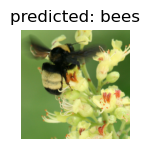

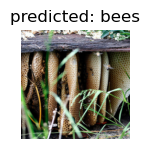

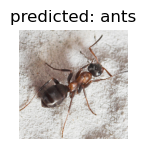

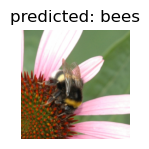

In [8]:
visualize_model(model_ft)

## ConvNet as Fixed Feature Extractor

A downside of retraining the whole neural network is that it takes too long of a time to retrain the entire parameters. Instead, we can freeze all the network except the final layer, and we can do this by setting `requires_grad = False` for most layers.

In [9]:
model_conv = torchvision.models.resnet18(weights = 'IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed layers have requires_grad = True by default
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# The only parameters of the final layer are being optimized, unlike before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=1e-3, momentum=.9)

# Decay the learning rate by a factor of .1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = .1)

# Train and Evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 6)

Epoch 0/5
----------
train Loss: 0.6059 Acc: 0.6393
val Loss: 0.4313 Acc: 0.8039

Epoch 1/5
----------
train Loss: 0.4082 Acc: 0.8279
val Loss: 0.4391 Acc: 0.8301

Epoch 2/5
----------
train Loss: 0.5034 Acc: 0.7787
val Loss: 0.1805 Acc: 0.9477

Epoch 3/5
----------
train Loss: 0.6138 Acc: 0.7377
val Loss: 0.1895 Acc: 0.9412

Epoch 4/5
----------
train Loss: 0.3301 Acc: 0.8443
val Loss: 0.1836 Acc: 0.9477

Epoch 5/5
----------
train Loss: 0.6295 Acc: 0.7582
val Loss: 0.2405 Acc: 0.9085

Training complete in 7m 1s
Best val Acc: 0.947712


C:\Users\srhee\AppData\Local\Temp\ipykernel_10884\1058781594.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


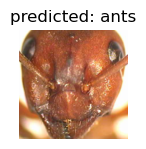

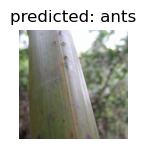

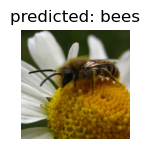

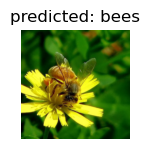

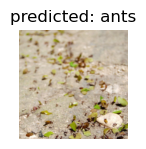

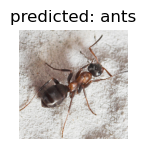

In [10]:
# Visualize the model
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on Custom Images

We can now use the trained model to make predictions on custom images. Here, we have used an image from the training set, but we can replace the value of `img_path` with appropriate file path to make predictions and visualize the results.

In [11]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

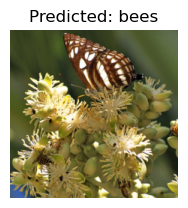

In [12]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Thank you for reading!